# FAISS Example 01: Basic Vector Search với Visualization
# Ví dụ 1: Tìm kiếm Vector cơ bản với Trực quan hóa

Notebook này minh họa:
- Tìm kiếm vector với FAISS IndexFlat
- Trực quan hóa vectors và kết quả tìm kiếm
- So sánh FAISS với NumPy brute-force
- Phân tích khoảng cách và độ chính xác

In [1]:
import numpy as np
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.decomposition import PCA
import sys
import os

# Add parent directory to path
sys.path.append(os.path.dirname(os.path.abspath('')))
from utils.data_generator import generate_random_vectors, generate_query_vectors
from utils.benchmark import benchmark_index, print_index_info

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Imports hoàn tất!")

✓ Imports hoàn tất!


## 1. Tạo dữ liệu test

In [2]:
# Configuration
dimension = 128
n_vectors = 10000
n_queries = 100
k = 10

print(f"Cấu hình:")
print(f"  Dimension: {dimension}")
print(f"  Database size: {n_vectors:,} vectors")
print(f"  Number of queries: {n_queries}")
print(f"  K neighbors: {k}")

# Generate data
np.random.seed(42)
database_vectors = generate_random_vectors(n_vectors, dimension)
query_vectors = generate_query_vectors(n_queries, dimension)

print(f"\n✓ Database vectors: {database_vectors.shape}")
print(f"✓ Query vectors: {query_vectors.shape}")
print(f"✓ Memory size: {database_vectors.nbytes / (1024**2):.2f} MB")

Cấu hình:
  Dimension: 128
  Database size: 10,000 vectors
  Number of queries: 100
  K neighbors: 10

✓ Database vectors: (10000, 128)
✓ Query vectors: (100, 128)
✓ Memory size: 4.88 MB


## 2. Xây dựng FAISS Flat Index

In [3]:
# Create and build index
print("Tạo IndexFlatL2...")
start_time = time.time()
index = faiss.IndexFlatL2(dimension)
index.add(database_vectors)
build_time = time.time() - start_time

print(f"✓ Build time: {build_time:.3f}s")
print_index_info(index, "Flat Index")

Tạo IndexFlatL2...
✓ Build time: 0.014s

Flat Index Information:
  Type: IndexFlatL2
  Dimension: 128
  Total vectors: 10000
  Is trained: True
  Metric type: 1
  Memory size: 4.88 MB


## 3. Tìm kiếm K-Nearest Neighbors

In [4]:
# Search
print(f"Tìm kiếm {k} nearest neighbors cho {n_queries} queries...")
start_time = time.time()
distances, indices = index.search(query_vectors, k)
search_time = time.time() - start_time

print(f"✓ Search time: {search_time:.3f}s")
print(f"✓ QPS: {n_queries / search_time:.1f}")
print(f"✓ Avg time per query: {search_time / n_queries * 1000:.3f} ms")
print(f"\nDistances shape: {distances.shape}")
print(f"Indices shape: {indices.shape}")

Tìm kiếm 10 nearest neighbors cho 100 queries...
✓ Search time: 0.098s
✓ QPS: 1017.2
✓ Avg time per query: 0.983 ms

Distances shape: (100, 10)
Indices shape: (100, 10)


## 4. Visualization - Phân tích kết quả

In [ ]:
# Visualize distance distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Distance distribution for all queries
ax = axes[0, 0]
ax.hist(distances.flatten(), bins=50, alpha=0.7, edgecolor='black')
ax.axvline(distances.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {distances.mean():.2f}')
ax.axvline(np.median(distances), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(distances):.2f}')
ax.set_xlabel('L2 Distance', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of All Distances', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Distance by rank (averaged across queries)
ax = axes[0, 1]
mean_distances_by_rank = distances.mean(axis=0)
std_distances_by_rank = distances.std(axis=0)
ranks = np.arange(1, k + 1)
ax.plot(ranks, mean_distances_by_rank, 'o-', linewidth=2, markersize=8)
ax.fill_between(ranks, 
                mean_distances_by_rank - std_distances_by_rank,
                mean_distances_by_rank + std_distances_by_rank,
                alpha=0.3)
ax.set_xlabel('Neighbor Rank', fontsize=12)
ax.set_ylabel('Average L2 Distance', fontsize=12)
ax.set_title('Distance vs Neighbor Rank', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xticks(ranks)

# Plot 3: Heatmap of distances for first 20 queries
ax = axes[1, 0]
n_show = min(20, n_queries)
sns.heatmap(distances[:n_show], ax=ax, cmap='YlOrRd', cbar_kws={'label': 'L2 Distance'})
ax.set_xlabel('Neighbor Rank', fontsize=12)
ax.set_ylabel('Query ID', fontsize=12)
ax.set_title(f'Distance Heatmap (First {n_show} Queries)', fontsize=14, fontweight='bold')

# Plot 4: Box plot of distances by rank
ax = axes[1, 1]
distance_data = [distances[:, i] for i in range(k)]
bp = ax.boxplot(distance_data, tick_labels=ranks, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
ax.set_xlabel('Neighbor Rank', fontsize=12)
ax.set_ylabel('L2 Distance', fontsize=12)
ax.set_title('Distance Distribution by Rank', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('01_distance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Đã lưu biểu đồ: 01_distance_analysis.png")

## 5. Visualization - PCA projection (2D)

Giảm chiều vectors từ 128D xuống 2D bằng PCA...
✓ PCA explained variance: 2.74%


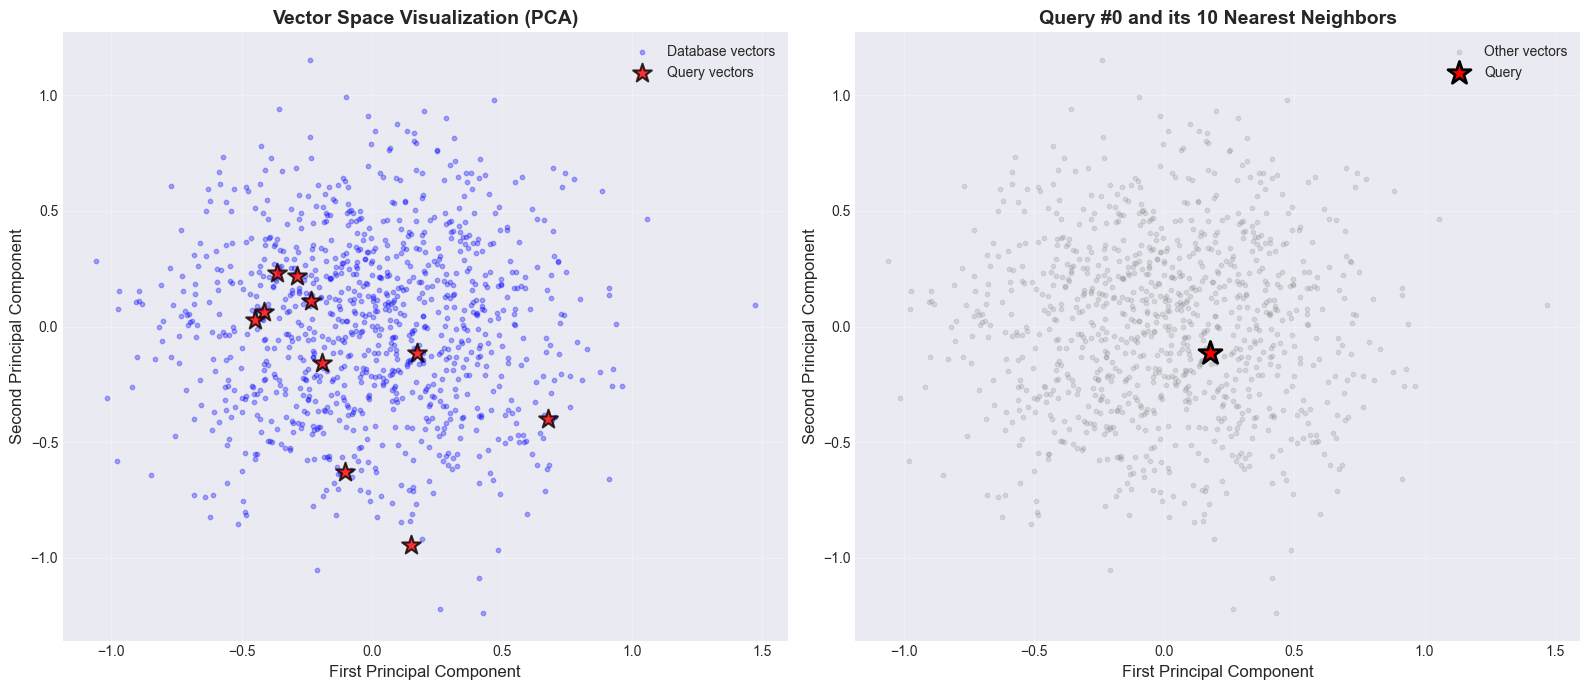

✓ Đã lưu biểu đồ: 01_vector_space_2d.png


In [6]:
# Visualize vectors in 2D using PCA
print("Giảm chiều vectors từ 128D xuống 2D bằng PCA...")
pca = PCA(n_components=2)

# Sample a subset for visualization
n_sample = 1000
sample_indices = np.random.choice(n_vectors, n_sample, replace=False)
sample_vectors = database_vectors[sample_indices]

# Fit PCA on sample + queries
all_vectors = np.vstack([sample_vectors, query_vectors[:10]])
pca.fit(all_vectors)

# Transform
sample_2d = pca.transform(sample_vectors)
queries_2d = pca.transform(query_vectors[:10])

print(f"✓ PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Overview
ax = axes[0]
ax.scatter(sample_2d[:, 0], sample_2d[:, 1], alpha=0.3, s=10, c='blue', label='Database vectors')
ax.scatter(queries_2d[:, 0], queries_2d[:, 1], alpha=0.8, s=200, c='red', 
           marker='*', edgecolors='black', linewidth=1.5, label='Query vectors', zorder=5)
ax.set_xlabel('First Principal Component', fontsize=12)
ax.set_ylabel('Second Principal Component', fontsize=12)
ax.set_title('Vector Space Visualization (PCA)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Detailed view - first query with its neighbors
ax = axes[1]
query_idx = 0
query_2d = queries_2d[query_idx]
neighbor_ids = indices[query_idx]

# Get original indices in sample
sample_id_map = {orig_id: i for i, orig_id in enumerate(sample_indices)}
neighbor_in_sample = [(nid, sample_id_map[nid]) for nid in neighbor_ids if nid in sample_id_map]

# Plot sample points
ax.scatter(sample_2d[:, 0], sample_2d[:, 1], alpha=0.2, s=10, c='gray', label='Other vectors')

# Plot query
ax.scatter(query_2d[0], query_2d[1], s=300, c='red', marker='*', 
           edgecolors='black', linewidth=2, label='Query', zorder=5)

# Plot neighbors
if neighbor_in_sample:
    neighbor_positions = sample_2d[[sid for _, sid in neighbor_in_sample]]
    ax.scatter(neighbor_positions[:, 0], neighbor_positions[:, 1], 
               s=100, c='green', marker='o', alpha=0.7,
               edgecolors='black', linewidth=1, label=f'Top {len(neighbor_in_sample)} neighbors', zorder=4)
    
    # Draw lines to neighbors
    for pos in neighbor_positions:
        ax.plot([query_2d[0], pos[0]], [query_2d[1], pos[1]], 
                'g--', alpha=0.3, linewidth=1)

ax.set_xlabel('First Principal Component', fontsize=12)
ax.set_ylabel('Second Principal Component', fontsize=12)
ax.set_title(f'Query #{query_idx} and its {k} Nearest Neighbors', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('01_vector_space_2d.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Đã lưu biểu đồ: 01_vector_space_2d.png")

## 6. So sánh FAISS vs NumPy

In [7]:
# Compare with NumPy brute-force
print("So sánh FAISS với NumPy brute-force...\n")

query = query_vectors[0:1]

# NumPy brute-force
start_time = time.time()
numpy_distances = np.sum((database_vectors - query)**2, axis=1)
k_smallest_idx = np.argsort(numpy_distances)[:k]
k_smallest_dist = numpy_distances[k_smallest_idx]
numpy_time = time.time() - start_time

# FAISS
start_time = time.time()
faiss_distances, faiss_indices = index.search(query, k)
faiss_time = time.time() - start_time

# Compare
print(f"Thời gian:")
print(f"  NumPy:  {numpy_time*1000:.3f} ms")
print(f"  FAISS:  {faiss_time*1000:.3f} ms")
print(f"  Speedup: {numpy_time/faiss_time:.1f}x")

print(f"\nĐộ chính xác:")
faiss_result = set(faiss_indices[0])
numpy_result = set(k_smallest_idx)
matches = len(faiss_result.intersection(numpy_result))
print(f"  Matching neighbors: {matches}/{k}")
print(f"  Accuracy: {matches/k*100:.1f}%")

dist_diff = np.abs(faiss_distances[0] - k_smallest_dist).max()
print(f"  Max distance difference: {dist_diff:.6f}")

if matches == k:
    print("\n✓ FAISS và NumPy cho kết quả GIỐNG NHAU!")
else:
    print("\n✗ Có sự khác biệt trong kết quả")

So sánh FAISS với NumPy brute-force...

Thời gian:
  NumPy:  11.295 ms
  FAISS:  0.551 ms
  Speedup: 20.5x

Độ chính xác:
  Matching neighbors: 10/10
  Accuracy: 100.0%
  Max distance difference: 0.000001

✓ FAISS và NumPy cho kết quả GIỐNG NHAU!


## 7. Performance Analysis

Benchmark với số lượng queries khác nhau...



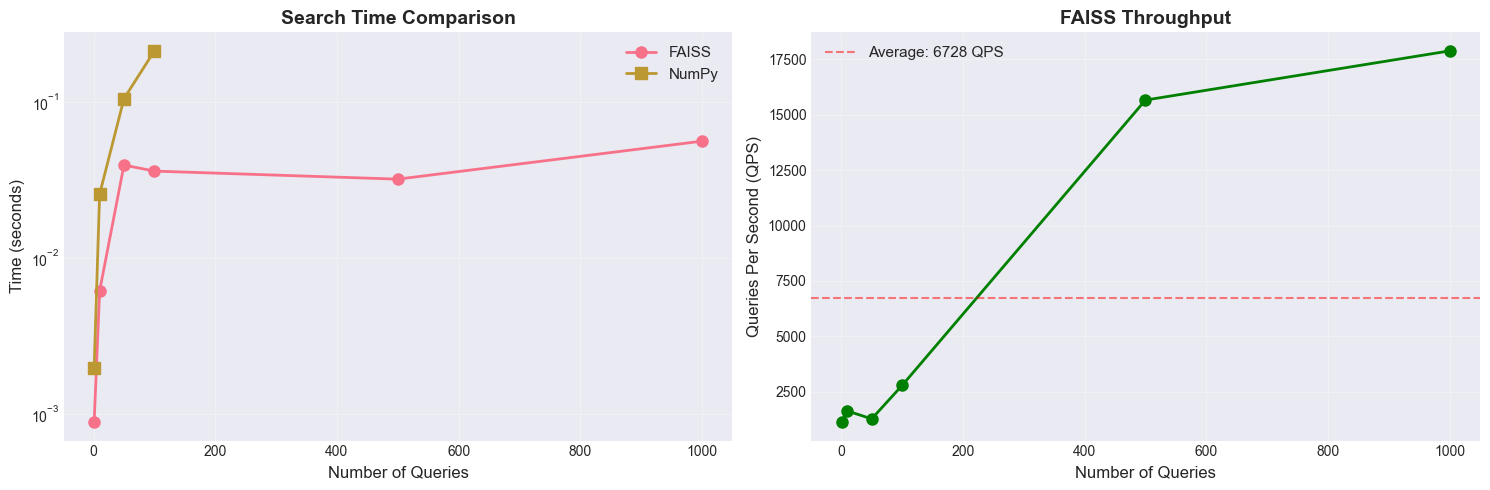

✓ Đã lưu biểu đồ: 01_performance_comparison.png


In [8]:
# Benchmark với số lượng queries khác nhau
print("Benchmark với số lượng queries khác nhau...\n")

query_counts = [1, 10, 50, 100, 500, 1000]
faiss_times = []
numpy_times = []

for n_q in query_counts:
    test_queries = query_vectors[:n_q]
    
    # FAISS
    start = time.time()
    index.search(test_queries, k)
    faiss_times.append(time.time() - start)
    
    # NumPy (only for smaller counts to save time)
    if n_q <= 100:
        start = time.time()
        for q in test_queries:
            dists = np.sum((database_vectors - q)**2, axis=1)
            np.argsort(dists)[:k]
        numpy_times.append(time.time() - start)
    else:
        numpy_times.append(None)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Absolute times
ax1.plot(query_counts, faiss_times, 'o-', linewidth=2, markersize=8, label='FAISS')
valid_numpy = [(q, t) for q, t in zip(query_counts, numpy_times) if t is not None]
if valid_numpy:
    ax1.plot([q for q, _ in valid_numpy], [t for _, t in valid_numpy], 
             's-', linewidth=2, markersize=8, label='NumPy')
ax1.set_xlabel('Number of Queries', fontsize=12)
ax1.set_ylabel('Time (seconds)', fontsize=12)
ax1.set_title('Search Time Comparison', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: QPS
faiss_qps = [n / t if t > 0 else 0 for n, t in zip(query_counts, faiss_times)]
ax2.plot(query_counts, faiss_qps, 'o-', linewidth=2, markersize=8, color='green')
ax2.set_xlabel('Number of Queries', fontsize=12)
ax2.set_ylabel('Queries Per Second (QPS)', fontsize=12)
ax2.set_title('FAISS Throughput', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=np.mean(faiss_qps), color='red', linestyle='--', 
            alpha=0.5, label=f'Average: {np.mean(faiss_qps):.0f} QPS')
ax2.legend(fontsize=11)

plt.tight_layout()
plt.savefig('01_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Đã lưu biểu đồ: 01_performance_comparison.png")

## 8. Tóm tắt

In [9]:
print("="*70)
print("TÓM TẮT - IndexFlatL2")
print("="*70)

print(f"\n✓ Đặc điểm:")
print(f"  - Accuracy: 100% (exact search)")
print(f"  - Build time: {build_time:.3f}s")
print(f"  - Search time: {search_time:.3f}s")
print(f"  - QPS: {n_queries/search_time:.1f}")
print(f"  - Memory: {database_vectors.nbytes / (1024**2):.2f} MB")

print(f"\n✓ Khi nào dùng:")
print(f"  - Dataset nhỏ (<100K vectors)")
print(f"  - Cần độ chính xác 100%")
print(f"  - Làm baseline để đánh giá các index khác")
print(f"  - Tạo ground truth cho experiments")

print(f"\n✓ Hạn chế:")
print(f"  - Chậm với dataset lớn (O(n) complexity)")
print(f"  - Không scale với hàng triệu vectors")
print(f"  - Nên dùng IVF, HNSW cho production")

print(f"\n" + "="*70)

TÓM TẮT - IndexFlatL2

✓ Đặc điểm:
  - Accuracy: 100% (exact search)
  - Build time: 0.014s
  - Search time: 0.098s
  - QPS: 1017.2
  - Memory: 4.88 MB

✓ Khi nào dùng:
  - Dataset nhỏ (<100K vectors)
  - Cần độ chính xác 100%
  - Làm baseline để đánh giá các index khác
  - Tạo ground truth cho experiments

✓ Hạn chế:
  - Chậm với dataset lớn (O(n) complexity)
  - Không scale với hàng triệu vectors
  - Nên dùng IVF, HNSW cho production

